In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
img_size = 256
content_img_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])

style_img_transforms = transforms.Compose([
    transforms.ToTensor()
])


In [22]:
import matplotlib.pyplot as plt
def img_show(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    

In [23]:
def content_image_loader(image_name):
    image = Image.open(image_name)
    image = content_img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

def style_image_loader(image_name):
    image = Image.open(image_name)
    image = style_img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = content_image_loader('/kaggle/input/style-transfer-images/content.jpg') # Content image
style_img = style_image_loader('/kaggle/input/style-transfer-images/style.jpg') # Style image
output_img = content_img.clone().requires_grad_(True).to(device)

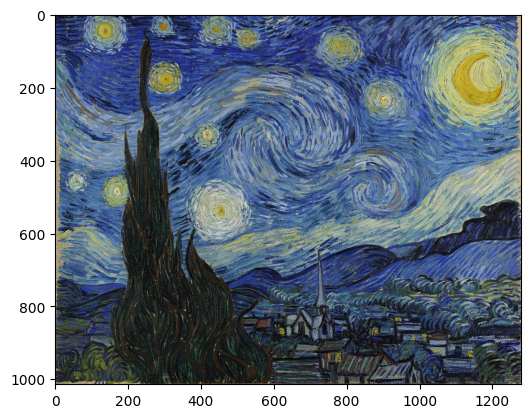

In [24]:
img_show(style_img)

In [25]:
# Model
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
for param in VGG19_pretrained.parameters():
    param.requires_grad_(False)

# model = VGG19_pretrained[:11]
# model.to(device)
VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [26]:
# Content Loss
content_weight = 1
ContentLoss = nn.MSELoss()

# Style loss
def gram_matrix(tensor):
    a,b,c,d = tensor.size()
    tensor = tensor.view(a*b,c*d)
    G = torch.mm(tensor,tensor.t())
    return G.div(a*b*c*d)

style_weight = 1e7
StyleLoss = nn.MSELoss()

In [27]:
def get_features(pretrained_model,image):
    layers = {
        "0":"conv_1",
        "5":"conv_2",
        "10":"conv_3",
        "19":"conv_4",
        "28":"conv_5"
    }

    features = {}
    x = image
    for name, layer in pretrained_model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [28]:
style_weights = {
    'conv_1': 1.0,
    'conv_2': 0.8,
    'conv_3': 0.5,
    'conv_4': 0.3,
    'conv_5': 0.1
}

In [29]:
# Training

import torch.optim as optim
optimizer = optim.Adam([output_img], lr=0.01)

STEPS = 1000

# style_features = model(style_img)
# style_gram = gram_matrix(style_features)

style_features = get_features(VGG19_pretrained,style_img)
content_features = get_features(VGG19_pretrained,content_img)

style_grams = {}
for layer in style_weights:
    style_grams[layer] = gram_matrix(style_features[layer])
# style_gram = gram_matrix(style_features['conv_5'])

for step in range(STEPS):
    optimizer.zero_grad()

    output_features = get_features(VGG19_pretrained,output_img)
    
    # Content loss
    content_loss = ContentLoss(content_features['conv_2'],output_features['conv_2'])

    # Style loss
    style_loss = 0
    for layer, w in style_weights.items():
        output_gram = gram_matrix(output_features[layer])
        style_loss += w * StyleLoss(style_grams[layer], output_gram)
    # style_loss = StyleLoss(style_gram, output_gram)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward()
    optimizer.step()
     
    
    with torch.no_grad():
        output_img.clamp_(0,1) 

    if step%100 == 0:
        print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.8f}")
        

Epoch [1/1000] Total loss: 77.98521423
Epoch [101/1000] Total loss: 0.81667310
Epoch [201/1000] Total loss: 0.64994669
Epoch [301/1000] Total loss: 0.58538163
Epoch [401/1000] Total loss: 0.54821068
Epoch [501/1000] Total loss: 0.52376032
Epoch [601/1000] Total loss: 0.50624895
Epoch [701/1000] Total loss: 0.49289113
Epoch [801/1000] Total loss: 0.48225409
Epoch [901/1000] Total loss: 0.47411394


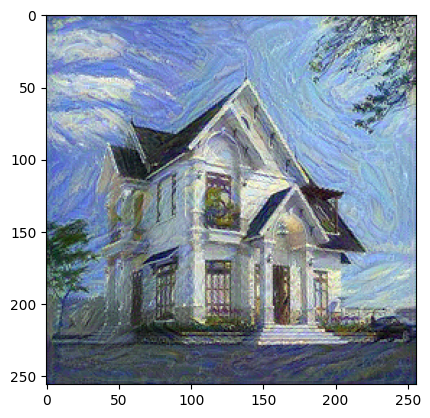

In [30]:
img_show(output_img)